In [2]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def D22(X):
    n, _ = np.shape(X)
    d22 = np.zeros((n, n))
    for i in range(n - 1):
        t = X[i] - X[i+1:]
        d22[i][i+1:] = np.sum(t*t, axis = 1)
    return d22 + d22.T

def heap_insert(heap, index_heap, value, index):
    c = len(heap)
    heap.append(value)
    index_heap.append(index)
    while c > 0:
        p = (c - 1) // 2
        if heap[p] < value:
            index_heap[c], heap[c] = index_heap[p], heap[p]
            index_heap[p], heap[p] = index, value
            c = p
        else:
            break

def heap_shift(heap, index_heap, value, index):
    N = len(heap)
    if N >= 1:
        heap[0], p, index_heap[0] = value, 0, index
        while True:
            c1, c2 = 2*p+1, 2*p+2
            if c1 >= N:
                break
            c = c1
            if c2 < N and heap[c1] < heap[c2]:
                c = c2
            if heap[p] < heap[c]:
                index_heap[p], heap[p] = index_heap[c], heap[c]
                index_heap[c], heap[c] = index, value
                p = c
            else:
                break

def heap_pop(heap, index_heap):
    beta = index_heap[0]
    value, index = heap[-1], index_heap[-1]
    heap, index_heap = heap[:-1], index_heap[:-1]
    heap_shift(heap, index_heap, value, index)
    return beta, heap, index_heap

def clustering(X, k, alpha):
    n, d = np.shape(X)
    d22, C, pd = D22(X), [], d / 2
    DR = np.array([np.argsort(d22[i]) for i in range(n)])
    unclustered, num_unclustered, theta = set(range(n)), n, 1
    while num_unclustered > k:
        for i in range(int(1/(1-alpha)) + 1):
            t1 = np.random.randn(num_unclustered, d)
            t2 = D22(t1)
            KNN, density = [], []
            for i in range(num_unclustered):
                t3, knn, heap = t2[i], [], []
                for j in range(k + 1):
                    heap_insert(heap, knn, t3[j], j)
                for j in range(k + 1, num_unclustered):
                    t4 = t3[j]
                    if t4 < heap[0]:
                        heap_shift(heap, knn, t4, j)
                knn.remove(i)
                KNN.append(knn)
                density.append(heap[0] ** pd)
            density /= np.mean(density)
            undetected, densest = set(range(num_unclustered)), np.argmax(density)
            dip, cur = np.zeros(num_unclustered), densest
            dip[densest] = density[densest]
            density_heap, point_heap = [], []
            undetected.remove(densest)
            loop = True
            while loop:
                for nn in KNN[cur]:
                    if nn in undetected:
                        undetected.remove(nn)
                        t1 = density[nn]
                        heap_insert(density_heap, point_heap, t1, nn)
                        t2, t3 = t1, dip[cur]
                        if t1 > t3:
                            t2 = t3
                        dip[nn] = t2
                beta, density_heap, point_heap = heap_pop(density_heap, point_heap)
                cur = beta
                if len(point_heap) == 0:
                    loop = False
            rsize_min = np.min(dip / density)
            if rsize_min < theta:
                theta = rsize_min
        KNN, density = np.zeros((n, k)), np.zeros(n)
        for nn in unclustered:
            dr, j, t1, l = DR[nn], 1, [], 0
            while l < k:
                t2 = dr[j]
                j += 1
                if t2 in unclustered:
                    t1.append(t2)
                    l += 1
            KNN[nn] = t1
            density[nn] = 1 / d22[t2][nn] ** pd
        density /= np.mean(density)
        KNN = KNN.astype(int)
        densest, dense = 0, 0
        for nn in unclustered:
            t1 = density[nn]
            if t1 > dense:
                dense, densest = t1, nn
        path, dip, point, rsize, cur = [[] for _ in range(n)], np.zeros(n), np.zeros(n), np.zeros(n), densest
        dip[densest], point[densest], rsize[densest] = dense, densest, 1
        path[densest].append(densest)
        cluster, density_heap, point_heap = set([densest]), [], []
        undetected = unclustered.copy()
        undetected.remove(densest)
        loop = True
        while loop:
            for nn in KNN[cur]:
                if nn in undetected:
                    undetected.remove(nn)
                    path[nn] = path[cur] + [nn]
                    t1 = density[nn]
                    heap_insert(density_heap, point_heap, t1, nn)
                    t2, t3, t4 = t1, nn, dip[cur]
                    if t1 > t4:
                        t2 = t4
                        t3 = point[cur]
                    dip[nn] = t2
                    rsize[nn] = t2 / t1
                    point[nn] = t3
            loop1 = True
            while loop1 > 0 and len(point_heap) > 0:
                beta, density_heap, point_heap = heap_pop(density_heap, point_heap)
                if rsize[beta] > theta:
                    cluster.add(beta)
                    cur = beta
                    loop1 = False
                else:
                    p, pt, i = path[beta], int(point[beta]), -1
                    t1 = p[-1]
                    while t1 != pt:
                        if t1 in cluster:
                            cluster.remove(t1)
                        i -= 1
                        t1 = p[i]
                    if np.random.randn() > 0 and pt in cluster:
                        cluster.remove(pt)
            if len(point_heap) == 0:
                loop = False
        C.append(list(cluster))
        unclustered -= cluster
        num_unclustered = len(unclustered)
    if num_unclustered > 0:
        C.append(list(unclustered))
    return C

def k_means(X, k):
    n, d = X.shape 
    x_min = np.min(X, axis = 0)
    m, x_gap = np.zeros((k, d)), np.max(X, axis = 0) - x_min
    for i in range(k):
        m[i] = x_min + x_gap * np.random.rand(d)
    c1 = np.zeros(n)
    while True:
        d22 = np.zeros((n, k))
        for i in range(k):
            d22[:, i] = np.sum((X - m[i]) ** 2, axis = 1)
        c2 = np.argmin(d22, axis = 1)
        if (c1 == c2).all():
            break
        c1 = c2
    c = [[] for _ in range(k)]
    for i in range(len(c2)):
        c[c2[i]].append(i)
    return c

def accuracy(CReal, CPred):
    n = np.sum([len(c) for c in CReal])
    H, NumInP, NumInR = [0] * n, len(CPred), len(CReal)
    for i in range(NumInP):
        for p in CPred[i]:
            H[p] = i
    error = []
    for i in range(NumInR):
        match = [0] * max(NumInR, NumInP)
        for p in CReal[i]:
            match[H[p]] += 1
        error.append(len(CReal[i]) - np.array(match))
    error = np.array(error)
    rc, pc = linear_sum_assignment(error)
    mis = 0
    for r, p in zip(rc, pc):
        mis += error[r][p]
    return 1 - mis / n

def radius(X, CPred):
    n, r2 = 0, 0
    for c in CPred:
        x = X[c]
        n += len(x)
        r2 += np.sum((x - np.mean(x, axis = 0)) ** 2)
    return np.sqrt(r2 / n)

def draw(X, C):
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    for c in C:
        color, x = '#', X[c]
        for i in range(6):
            color += colorArr[np.random.randint(0,14)]
        plt.scatter(x[:, 0],x[:, 1], c = color)
        
def RandomPointExperiment(expect = [(500, 0, 0), (500, 5, 5)], alpha = 0.8):
    n, h, CReal, X, lreal = 0, 0, [], [], 0
    for i in expect:
        X.append(np.random.normal(loc=0, scale=1, size=(i[0], 2)) + np.array([i[1], i[2]]))
        h += i[0]
        CReal.append(set(range(n, h)))
        n = h
    X = np.concatenate(X)
    lreal /= n
    CPred = clustering(X, 2 * int(np.log(n)), alpha = alpha)
    print("M-DIP")
    print("Accuracy:", 100 * accuracy(CReal, CPred), "%")
    print("Radius:", radius(X, CPred))
    draw(X, CPred)
    plt.show()
    CPred = k_means(X, len(CPred))
    print("K-MEANS")
    print("Accuracy:", 100 * accuracy(CReal, CPred), "%")
    print("Radius:", radius(X, CPred))
    draw(X, CPred)

def cut(adjacency_list, C):
    n = 0
    for c in C:
        cs = set(c)
        for node in c:
            for neigh in adjacency_list[node]:
                if neigh in cs:
                    n += 1
    return (np.sum([len(neigh) for neigh in adjacency_list]) - n) // 2
    
def RealDataExperiment(d = 10):
    f = open("ca-GrQc.txt", "r")
    rows, nodes = [line for line in f.readlines()][4:], []
    for i in range(len(rows)):
        [n1, n2] = [int(j) for j in rows[i].split()]
        nodes.append(n1)
        nodes.append(n2)
        rows[i] = (n1, n2)
    nodes = set(nodes)
    index, i = {}, 0
    for node in nodes:
        index[node] = i
        i += 1
    adjacency_list, laplacian_matrix = [[] for _ in range(i)], np.zeros((i, i))
    for n1, n2 in rows:
        i1, i2 = index[n1], index[n2]
        if i1 != i2:
            adjacency_list[i1].append(i2)
            laplacian_matrix[i1][i2] = -1
    for i in range(len(adjacency_list)):
        adjacency_list[i] = np.sort(adjacency_list[i]).tolist()
        laplacian_matrix[i][i] = len(adjacency_list[i])
    X = PCA(n_components = d).fit_transform(laplacian_matrix)
    print("M-DIP")
    C = clustering(X, 20, alpha = 0.8)
    print('Cut:', cut(adjacency_list, C))
    print("K-MEANS")
    print('Cut:', cut(adjacency_list, k_means(X, len(C))))

M-DIP
Accuracy: 98.75 %
Radius: 1.575616543310983


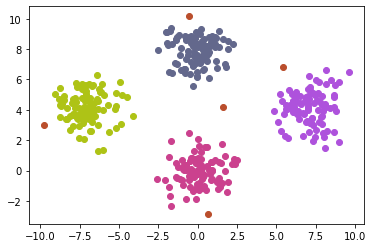

K-MEANS
Accuracy: 77.75 %
Radius: 2.901965879587982


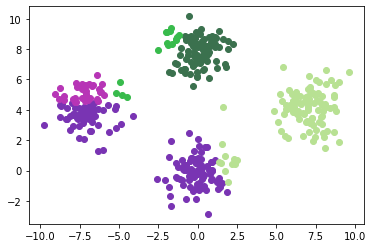

In [8]:
RandomPointExperiment([(100, 0, 0), (100, -7, 4), (100, 0, 8), (100, 7, 4)], alpha = 0.9)

In [3]:
RealDataExperiment()

M-DIP
Cut: 6891
K-MEANS
Cut: 702
